# Import libraries

In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time
import cv2
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
import mediapipe as mp
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from collections import Counter

2022-04-12 11:46:16.598115: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [3]:
ROUND = 2
EXERCISE = 'half-burpee'
CUR_CLASS = 'out'
PREV_CLASS = 'in'
SUBFIX_VID_NAME = '_hard_vote_r2'
REMOTE = True

# Initialize Mediapipe objects

In [4]:
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Load the data from disk

In [5]:
all_file_paths = []

In [6]:
SEQ_LEN = 8
if REMOTE:
    walk_path = f'/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_{SEQ_LEN}/{EXERCISE}'
else:
    walk_path = f'D:\EzFit_dataset\keypoints_seq\len_{SEQ_LEN}\{EXERCISE}'
for path, subdirs, files in tqdm(os.walk(walk_path)):
    for file_name in files:
        if file_name.endswith('.npy'):
            full_path = os.path.join(path, file_name)
            if 'idle' not in full_path:
                all_file_paths.append(full_path)

3179it [00:00, 85623.33it/s]


In [7]:
all_file_paths

['/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/1057/others_1057.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/809/others_809.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/1025/others_1025.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/937/others_937.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/517/others_517.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/240/others_240.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/1443/others_1443.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/760/others_760.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/143/others_143.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half

In [8]:
# use to check the balance of data
labels = list(map(lambda x: x.split(os.path.sep)[-3], all_file_paths))
labels

['others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',

In [9]:
# will be use for class weighting later
total = len(labels)
label_count = Counter(labels)
label_count, total

(Counter({'others': 1500, 'half-burpee-in': 1491, 'half-burpee-out': 2309}),
 5300)

In [10]:
def load_numpy(path):
    return np.load(path.numpy())

In [11]:
def load_data(file_path):
    # load numpy, file_path is Tensor with dtype string
    # and np.load not working with Tensor, so we need to work around with pure tf ops
    # this function return a list with elements following Tout, 
    # so we need to access first item
    data = tf.py_function(load_numpy, inp=[file_path], Tout=[tf.float32])[0] # return as tensor with dtype tf.float32

    # get label
    label_str = tf.strings.split(file_path, os.path.sep)[-3]
    one_hot = label_str == le.classes_ # get tensor with dtype bool
    label = tf.cast(one_hot, tf.int32)
    return data, label

# Preprocess Data

In [12]:
le = LabelEncoder()
le.fit(labels)
le.classes_

array(['half-burpee-in', 'half-burpee-out', 'others'], dtype='<U15')

In [13]:
labels = le.transform(labels)
labels

array([2, 2, 2, ..., 1, 1, 1])

In [14]:
train_paths, test_paths = train_test_split(all_file_paths, test_size=0.1, random_state=42, stratify=labels)

In [15]:
len(train_paths), len(test_paths)

(4770, 530)

# Class weighting
Since we have a bit imbalanced data, so we should do class weighting  
formula derived from here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

In [16]:
NUM_CLASSES = len(le.classes_)
class_weights = {}
for label in label_count:
    class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)

In [17]:
class_weights

{2: 1.1777777777777778, 0: 1.184887100380058, 1: 0.7651219864299119}

# Build data pipeline

In [18]:
# define hyperparameters
EPOCHS = 150
BATCH_SIZE = 32
NUM_CLASSES = len(le.classes_)
INIT_LR = 1e-3

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = (train_ds
            .shuffle(len(train_paths), seed=42)
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

2022-04-12 11:46:17.532612: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-12 11:46:17.571279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 11:46:17.571799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-04-12 11:46:17.571813: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-12 11:46:17.573261: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-12 11:46:17.573286: I tensorflow/stream_executor/plat

In [20]:
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = (test_ds
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

In [21]:
# check the shape and dtype
next(iter(train_ds))

2022-04-12 11:46:18.098767: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-12 11:46:18.099729: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3499880000 Hz
2022-04-12 11:46:18.143890: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(32, 8, 99), dtype=float32, numpy=
 array([[[0.20185654, 0.73411036, 0.9983353 , ..., 0.50427645,
          0.81853104, 0.79525286],
         [0.20319897, 0.73209035, 0.9984688 , ..., 0.46647027,
          0.83516407, 0.7726962 ],
         [0.20398723, 0.7310474 , 0.9985359 , ..., 0.41392824,
          0.8354705 , 0.7428529 ],
         ...,
         [0.18292573, 0.70830435, 0.9987305 , ..., 0.3974113 ,
          0.8691332 , 0.65799373],
         [0.16672172, 0.69675386, 0.9987757 , ..., 0.4052743 ,
          0.8622276 , 0.63118684],
         [0.16157678, 0.69339615, 0.99868554, ..., 0.42195576,
          0.86192423, 0.6016353 ]],
 
        [[0.8512931 , 0.70000285, 0.9999322 , ..., 0.13127123,
          0.7879291 , 0.9514457 ],
         [0.85067093, 0.66758823, 0.99993044, ..., 0.13276532,
          0.7886568 , 0.95058894],
         [0.84843194, 0.63535744, 0.99993134, ..., 0.13213241,
          0.78970015, 0.9501182 ],
         ...,
         [0.8405752 , 0.55255973,

# Build and Train LSTM Model

**require collecting new datasets**

In [22]:
# define callback (tensorboard)
log_dir = os.path.join('Logs')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

2022-04-12 11:46:18.173111: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-12 11:46:18.173131: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-04-12 11:46:18.173163: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-04-12 11:46:18.173614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64
2022-04-12 11:46:18.174126: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-04-12 11:46:18.257071: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-12 11:46:18.257175: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


In [23]:
# อาจจะปรับ fps ของ input วิดีโอได้ ให้ realistic กับที่ใช้จริง

In [24]:
# build model
model = tf.keras.models.Sequential([
    # ลด lstm จำนวน unit 64
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu', input_shape=(SEQ_LEN, 99)),
#     tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
#     tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                41984     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 48,803
Trainable params: 48,803
Non-trainable params: 0
_________________________________________________________________


In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [27]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/150


2022-04-12 11:46:19.181519: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  1/150 [..............................] - ETA: 2:23 - loss: 1.1791 - accuracy: 0.3750

2022-04-12 11:46:19.512611: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-04-12 11:46:19.587297: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-12 11:46:19.587314: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/150 [..............................] - ETA: 32s - loss: 1.1267 - accuracy: 0.3542

2022-04-12 11:46:19.794481: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-12 11:46:19.808264: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-04-12 11:46:19.840070: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 626 callback api events and 623 activity events. 
2022-04-12 11:46:19.856198: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-12 11:46:19.891705: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_04_12_11_46_19
2022-04-12 11:46:19.919338: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_04_12_11_46_19/jarvis.trace.json.gz
2022-04-12 11:46:19.945694: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

150/150 [==============================] - 4s 23ms/step - loss: 0.7974 - accuracy: 0.5958 - val_loss: 0.6728 - val_accuracy: 0.6849
Epoch 2/150
150/150 [==============================] - 1s 10ms/step - loss: 0.6540 - accuracy: 0.6751 - val_loss: 0.5594 - val_accuracy: 0.7094
Epoch 3/150
150/150 [==============================] - 2s 10ms/step - loss: 0.5855 - accuracy: 0.7168 - val_loss: 0.5514 - val_accuracy: 0.7981
Epoch 4/150
150/150 [==============================] - 1s 10ms/step - loss: 0.5431 - accuracy: 0.7296 - val_loss: 0.5014 - val_accuracy: 0.7547
Epoch 5/150
150/150 [==============================] - 1s 10ms/step - loss: 0.4945 - accuracy: 0.7618 - val_loss: 0.4435 - val_accuracy: 0.8113
Epoch 6/150
150/150 [==============================] - 1s 10ms/step - loss: 0.4675 - accuracy: 0.7786 - val_loss: 0.4284 - val_accuracy: 0.8170
Epoch 7/150
150/150 [==============================] - 1s 10ms/step - loss: 0.4472 - accuracy: 0.7874 - val_loss: 0.3743 - val_accuracy: 0.8377
Epoc

# Setup all dirs

In [29]:
import os

In [30]:
all_dirs = []
model_dir = f'saved_models/round_{ROUND}/{EXERCISE}/'
all_dirs.append(model_dir)
pickle_dir = f'saved_pickles/round_{ROUND}/{EXERCISE}/'
all_dirs.append(pickle_dir)
output_vid_dir = f'output_videos/round_{ROUND}/{EXERCISE}/'
all_dirs.append(output_vid_dir)

In [31]:
for d in all_dirs:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# Save model

In [32]:
model.save(f'saved_models/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq.h5', save_format='h5')

In [33]:
# serialize lb
with open(f'saved_pickles/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq_le.pickle', 'wb') as file:
    pickle.dump(le, file)

In [34]:
# command to run tensorboard
# first, going logs directory then,
# tensorboard --logdir=.

# Evaluation

In [35]:
raw_preds_y = model.predict(test_ds)
preds_y = np.argmax(raw_preds_y, axis=1)
preds_y

array([1, 2, 1, 0, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 2,
       2, 1, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0,
       2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2,
       0, 0, 1, 0, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 2,

In [36]:
# get y label back from tf.data
raw_test_y = np.concatenate([y for x, y in test_ds], axis=0)
test_y = np.argmax(raw_test_y, axis=1)
test_y

array([1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 2,
       2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0,
       2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2,
       0, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0,
       0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2,

In [37]:
test_y_text = le.inverse_transform(test_y)
preds_y_text = le.inverse_transform(preds_y)

### Accuracy

In [38]:
# better result with weight decay and patience = 7
_, acc = model.evaluate(test_ds)
print('Test accuracy:', acc)

17/17 [==============================] - 0s 3ms/step - loss: 0.0641 - accuracy: 0.9736
Test accuracy: 0.9735848903656006


### Confusion Matrix

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
cm = confusion_matrix(test_y_text, preds_y_text, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

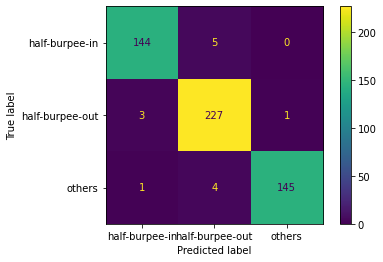

In [41]:
disp.plot()
plt.savefig(f'saved_artifacts/conf_matrix/final/{EXERCISE}/kps_seq_cm_r2.png', dpi=300)
plt.show()

### ROC AUC

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
roc_auc_score(raw_test_y, raw_preds_y)

0.999289875535994

# Detect in realtime

In [44]:
loaded_model = tf.keras.models.load_model(f'saved_models/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq.h5')

In [45]:
loaded_model.inputs

[<KerasTensor: shape=(None, 8, 99) dtype=float32 (created by layer 'lstm_input')>]

In [46]:
loaded_model.outputs

[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_3')>]

In [47]:
# load le
with open(f'saved_pickles/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq_le.pickle', 'rb') as file:
    loaded_le = pickle.load(file)

In [48]:
from collections import deque, Counter

In [49]:
# TODO: Run jumping-jack kps seq no hard-vote again
NUM_TEST_VIDS = 3
SEQ_LEN = 8
for i in range(1,1+NUM_TEST_VIDS):
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    rep_count = 0
    current_stage = None
    previous_stage = None
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360) # original is (1920, 1080)
    video_writer = cv2.VideoWriter(f'output_videos/round_{ROUND}/{EXERCISE}/{EXERCISE}_{i}_kps_seq{SUBFIX_VID_NAME}.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                                   25, video_size)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)

                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq)
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUBFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        
                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    class_name = "None"
                    prob = 0

                # count the rep logic
                current_stage = class_name

                if current_stage == f'{EXERCISE}-{CUR_CLASS}' and previous_stage == f'{EXERCISE}-{PREV_CLASS}':
                    rep_count += 1

                previous_stage = current_stage

                print('rep:',rep_count, end='\r')
                
                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

                # display rep count
                cv2.putText(image, 'Rep', (640-52, 0+15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(rep_count), (640-52, 0+50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)

            except Exception as e:
                print('[INFO] error:', e)

            video_writer.write(image)
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        cap.release()
        video_writer.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark' 0.99999757
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' obje

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark' 0.9992804618
[INFO] error: 'NoneType' ob

In [50]:
# # FOR DRAWING VISUALIZE
# cap = cv2.VideoCapture(f'objective_test_videos/squat/squat_3.mp4')
# video_size = (360, 640)

# with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
#     while cap.isOpened():
#         success, frame = cap.read()
#         if not success:
#             break

#         image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#         image = cv2.resize(image, (360, 640))

#         image.flags.writeable = False

#         results = pose.process(image)

#         image.flags.writeable = True
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

#         # Pose Detections
#         mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
#                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
#                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
#                                  )

#         # status box at top left corner
#         cv2.rectangle(image, (0,0), (220,50), (245,117,16), -1)

#         # display class
#         cv2.putText(image, 'Class', (95, 12),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
#         cv2.putText(image, 'squat-up', (95, 40),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)

#         # display prob
#         cv2.putText(image, 'Prob', (15, 12),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
#         cv2.putText(image, str(0.9811), (10, 40),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)

#         # rep count box at top right corner
#         cv2.rectangle(image, (300, 0), (640, 50), (245,117,16), -1)

#         # display rep count
#         cv2.putText(image, 'Rep', (355-52, 0+10),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
#         cv2.putText(image, str(10), (355-52, 0+50),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

#         cv2.imshow('Squat Count Detection', image)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()

# Save class for visualization
only best performing model

In [51]:
NUM_TEST_VIDS = 3
SEQ_LEN = 8
for i in range(1, 1+NUM_TEST_VIDS):
    predicted_class = []
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)
                
                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq)
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUBFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                        predicted_class.append(voted_pred)
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        predicted_class.append(y_idx)
                        
                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    predicted_class.append(0)
                    class_name = "None"
                    prob = 0
               
                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

            except Exception as e:
                predicted_class.append(0)
                print('[INFO] error:', e)
            
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        
        assert len(predicted_class) == total_frame, f"# of label {len(predicted_class)} != # of frames in the video {total_frame}"
        
        temp_save_path = f'saved_pickles/for_visualization/{EXERCISE}/test_vid_{i}/round_{ROUND}'
        if not os.path.exists(temp_save_path):
            os.makedirs(temp_save_path, exist_ok=True)
        with open(os.path.join(temp_save_path, f'test_vid_{i}_kps_seq{SUBFIX_VID_NAME}.pickle'), 'wb') as f:
            pickle.dump(predicted_class, f)
        cap.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark' 0.99999757
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' obje

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark' 0.9992804618
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' ob